Imports

In [1]:
from __future__ import print_function, division
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
from pathlib import Path
import nibabel as nib
from torch.optim import lr_scheduler
import math
from skimage import measure

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Create utilities for reading from the nib files. Use the nib utils to read a single instance for a given ID from the SISS Dataset. The Dataset object hails from the Torch's Dataset API and is used for creating an iterator tape to read from. Just pass the index over the tape to extract that sample instance.

In [2]:
ROOT_DIR = Path.cwd()
NUM_SLICES = 154

In [3]:
def read_nib(path):
    'read from the path'
    img = nib.load(str(path))
    data = img.get_fdata()
    return np.array(data)


def read_single_scan(scan_slice):
    'read the first 4 CT scan slices and 1 mask'
    scan_idx, slice_idx = scan_slice
    scan_dir = ROOT_DIR / 'data' / str(scan_idx)
    scan_data = []
    paths = sorted([x for x in scan_dir.iterdir()])
    for path in paths:
        if path.is_dir():
            scan_type = path / (path.name + '.nii')
            scan_data.append(read_nib(scan_type)[:, :, slice_idx])

    return np.stack(scan_data, axis=-1)

class SISSDataset(Dataset):
    """SISS dataset."""

    def __init__(self, num_slices, num_scans, root_dir, transform=None):
        """
        Args:
            num_slices (int): 154 for number of slices
            num_scans (int): 3 scans available
            root_dir (string): Directory with all the NIB scan blobs.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.num_slices = 154
        self.num_scans = 3
        self.total_samples = num_slices * num_scans
        self.sample_to_path = lambda x: (math.floor(x / NUM_SLICES)+1, x % NUM_SLICES)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return self.total_samples
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = read_single_scan(self.sample_to_path(idx))
        
        if self.transform:
            sample = self.transform((idx,sample))

        return sample

Create the dataset object

In [4]:
siss_dataset = SISSDataset(num_slices=154,
                          num_scans=3,
                          root_dir = Path.cwd())

Visualize random samples

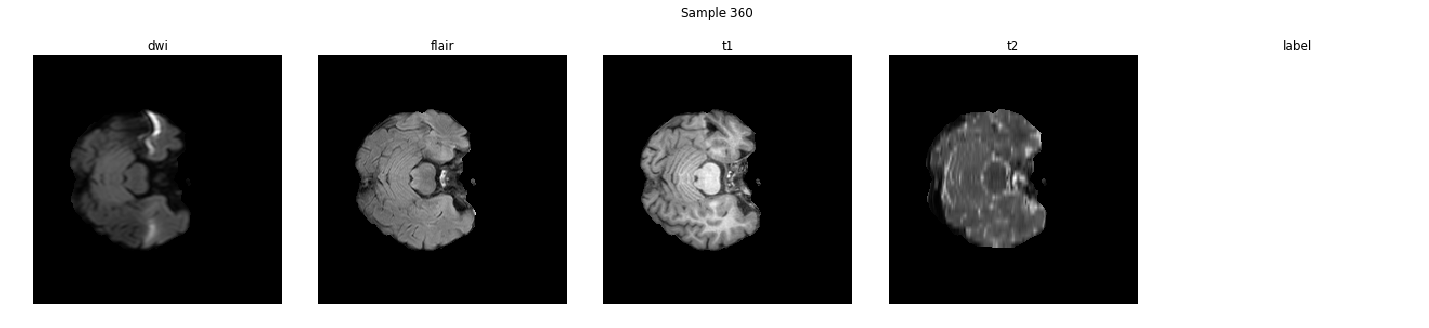

In [5]:
def show_single_img(image, label):
    """Show image"""
    cmap = 'gray'
    if label:
        cmap = 'binary'
    plt.imshow(image, cmap = cmap)

def viz_sample(sample):
    
    fig = plt.figure(figsize= (20,5))
    fig.suptitle('Sample %d' % idx)

    for slice_, scan in enumerate(['dwi', 'flair', 't1', 't2', 'label']):
        ax = plt.subplot(1, 5, slice_ + 1)
        show_single_img(sample[:,:, slice_], scan == 'label')
        plt.tight_layout()
        ax.set_title(scan)
        ax.axis('off')

    plt.show()

idx = np.random.randint(0, siss_dataset.total_samples)
sample = siss_dataset[idx]
viz_sample(sample)

Creating Transformations for Rescaling and Rescaling. The Rescale function has to apply the respective transformation function on the image object

In [6]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        # Decouple sample into id and image stack components
        idx, sample = sample
        
        h, w = sample.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(sample, (new_h, new_w))

        return idx,sample

class RandomRotate(object):
    """Rotate randomly the image in a sample."""

    def __call__(self, sample):
        # Decouple sample into id and image stack components
        idx, sample = sample
        
        # generate a random angle between 0 to 20 degrees
        angle = np.random.uniform(0, 1) * 20.0

        # apply rotation
        sample = transform.rotate(sample, angle)
        
        return idx,sample

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        # Decouple sample into id and image stack components
        idx, sample = sample
        
        h, w = sample.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        sample = sample[top: top + new_h,
                      left: left + new_w, :]

        return idx,sample

class ToNumpyDict(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        # Decouple sample into id and image stack components
        idx, sample = sample

        # get the scans and the mask label.
        scans, label = sample[:, :, :-1], sample[:, :, -1][..., np.newaxis]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        scans, label = scans.transpose((2, 0, 1)), \
        label.transpose((2, 0, 1))

        return {
                'idx': idx,
                'scan': scans,
                'label': label}

class ToMaskRCNNDataset(object):
    """
    Has to ideally format the mask to return the following:
    * image: a PIL Image of size (H, W)
    * target: a dict containing the following fields
        * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
        * `labels` (`Int64Tensor[N]`): the label for each bounding box
        * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
        * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
        * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
        * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
        * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation
    """
    
    def __call__(self, sample):      
        # get idx
        idx = sample['idx']
        
        # split the dict into component key-val pairs
        scan, mask = sample['scan'], sample['label']
        
        # get the different blobs, which are the connected components in the mask
        blobs_labels = measure.label(mask, background=0)

        # instances are encoded as different colors
        obj_ids = np.unique(blobs_labels)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set of binary masks
        masks = blobs_labels == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        # get the area of every box
        area = torch.zeros(1)
        if list(boxes.size()) != [0]:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = idx
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return scan, target

Instantiate the transforms and create the transform object. For every transform applied, show the image after the each transform and the cumulative application of the transforms.

<Figure size 432x288 with 0 Axes>

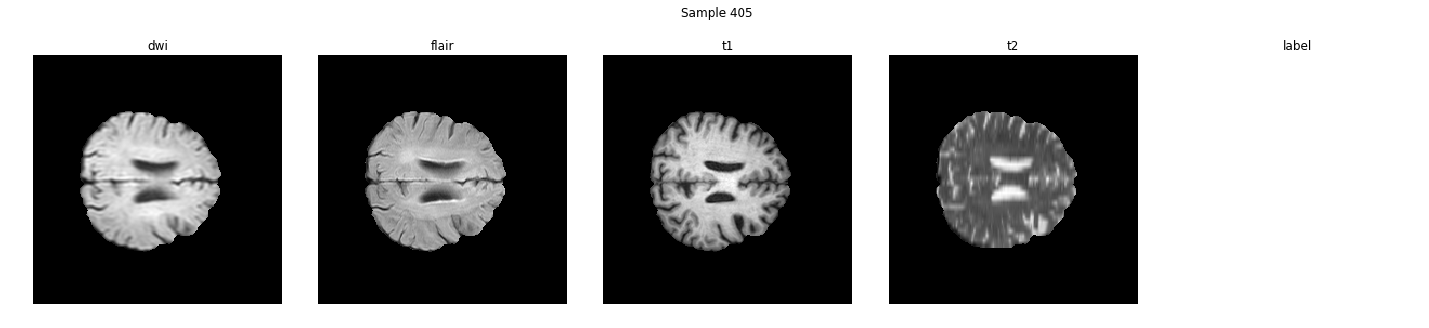

Rescale


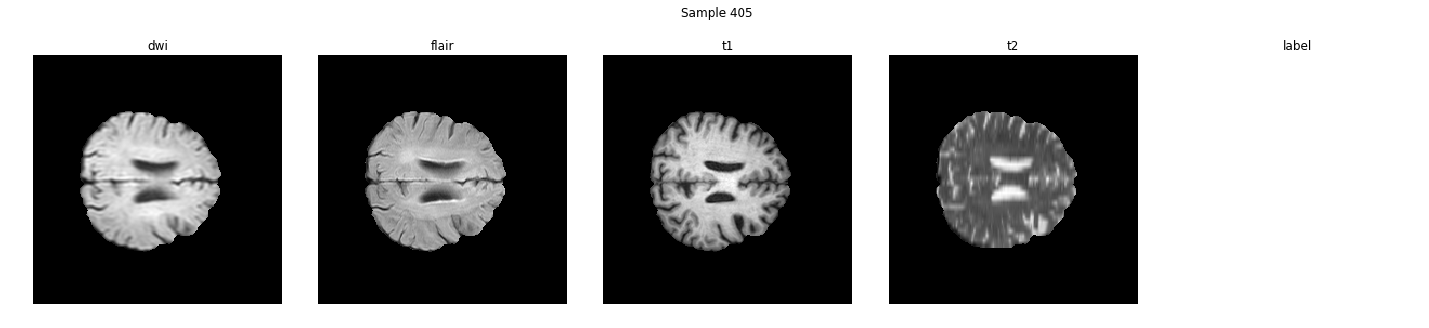

RandomCrop


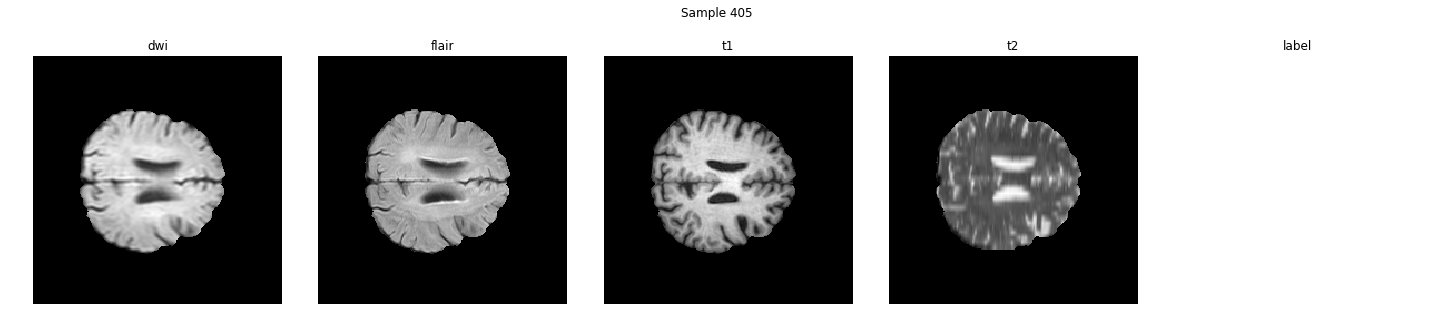

RandomRotate


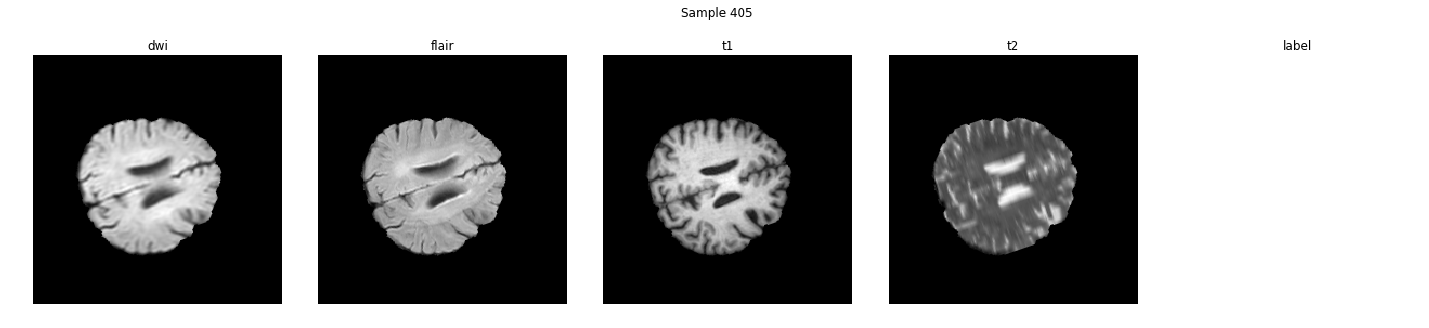

Compose


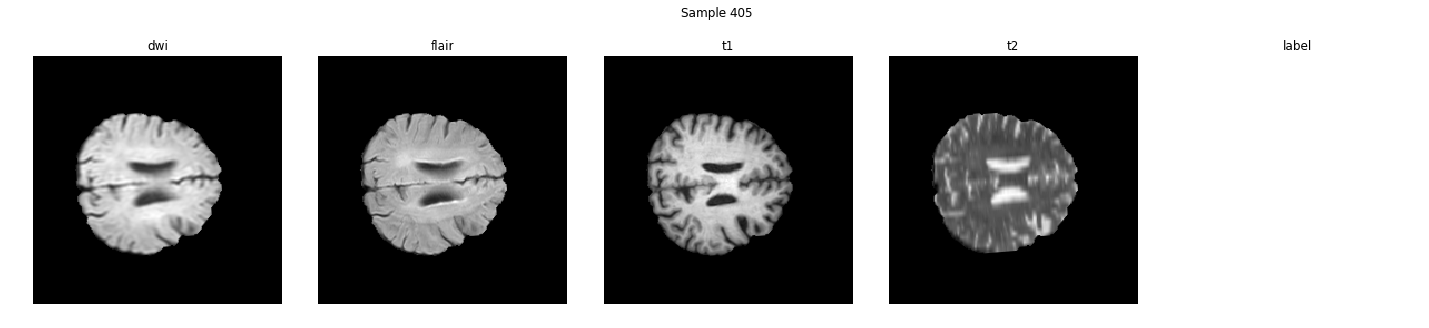

In [7]:
scale = Rescale(int(1.5 * 230))
crop = RandomCrop(224)
rotate = RandomRotate()
composed = transforms.Compose([Rescale(int(1.5 * 230)),
                               RandomRotate(),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
idx = np.random.randint(0, siss_dataset.total_samples)
sample = siss_dataset[idx]

viz_sample(sample)

for i, tsfrm in enumerate([scale, crop, rotate, composed]):
    transformed_sample = tsfrm((idx,sample))

    print(type(tsfrm).__name__)
    
    # get transformed sample
    idx, transformed_sample = transformed_sample
    viz_sample(transformed_sample)

Get the transformed dataset.

In [8]:
from torchvision.transforms import functional as torchv_functional

class ToTensor(object):
    def __call__(self, sample):
        image, target = sample
        image = torchv_functional.to_tensor(image)
        return image, target

In [9]:
transformed_dataset = SISSDataset(num_slices=154,
                          num_scans=3,
                          root_dir = Path.cwd(),
                           transform=transforms.Compose([
                               Rescale(int(1.5 * 230)),
                               RandomRotate(),
                               RandomCrop(224),
                               ToNumpyDict(),
                               ToMaskRCNNDataset(),
                               ToTensor()
                           ]))

for i in range(50,len(transformed_dataset)):
    img, target = transformed_dataset[i]
    
    print('img', img)
    print(target)

    if i == 53:
        break

img tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0

ID that has 2 segmented regions

In [12]:
idx

197

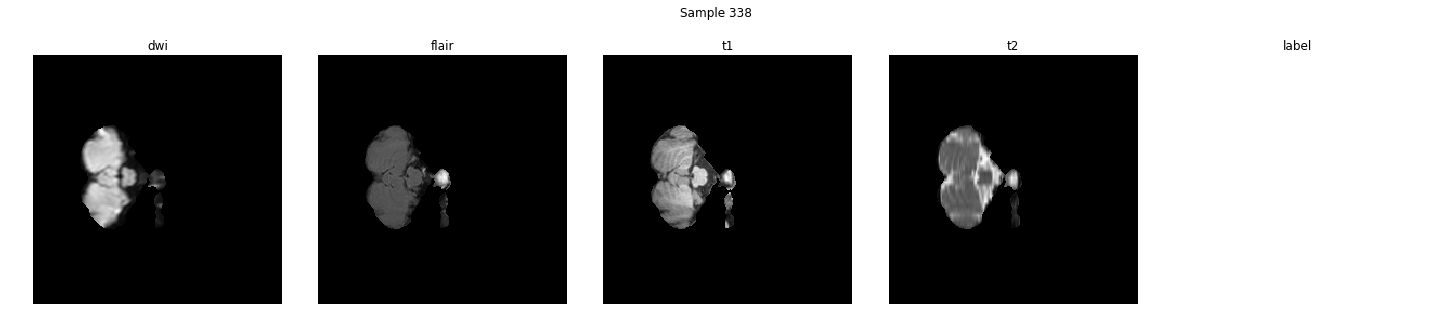

In [13]:
idx = np.random.randint(0, siss_dataset.total_samples)
sample = siss_dataset[idx]

viz_sample(sample)

transformed_sample = composed((idx,sample))

Use this SISS Torch Dataset with the Torch DataLoader for batching, shuffling and for multiprocessing

In [14]:
transformed_dataset_viz = SISSDataset(num_slices=154,
                          num_scans=3,
                          root_dir = Path.cwd(),
                           transform=transforms.Compose([
                               Rescale(int(1.5 * 230)),
                               RandomRotate(),
                               RandomCrop(224),
                               ToNumpyDict(),
                               ToMaskRCNNDataset(),
                               ToTensor()
                           ]))
dataloader = DataLoader(transformed_dataset_viz, batch_size=1,
                        shuffle=True, num_workers=4)

In [15]:
next(iter(dataloader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.

0 torch.Size([4, 4, 224, 224]) torch.Size([4, 1, 224, 224])


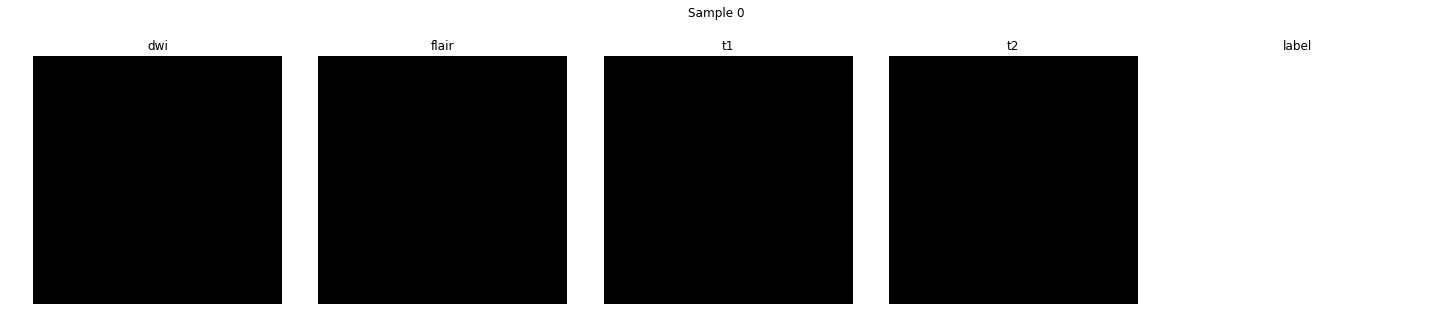

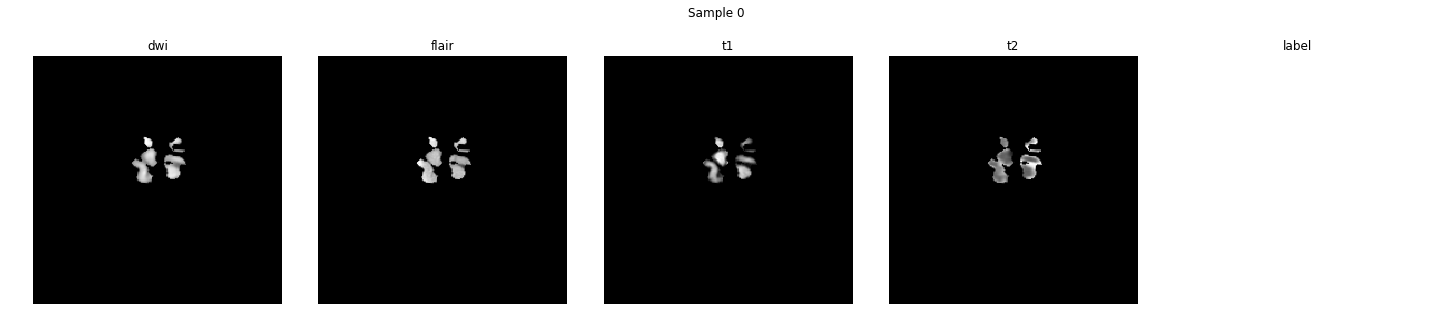

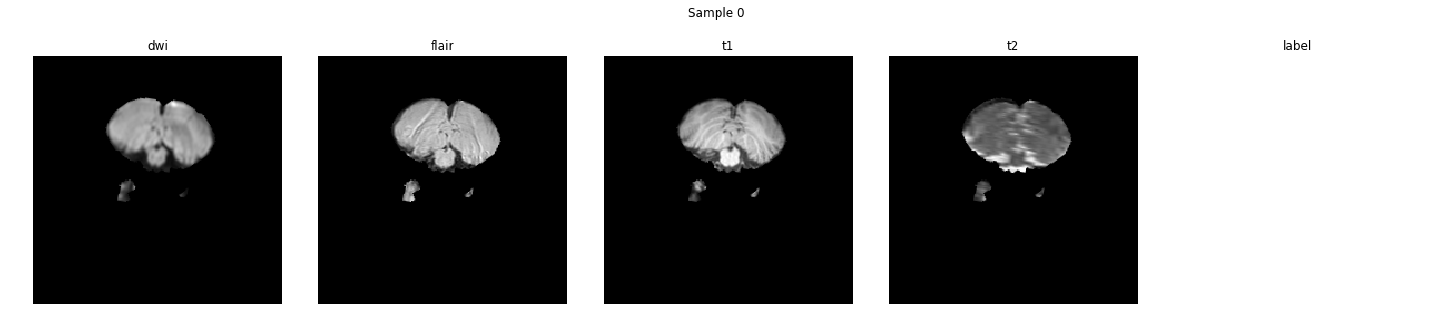

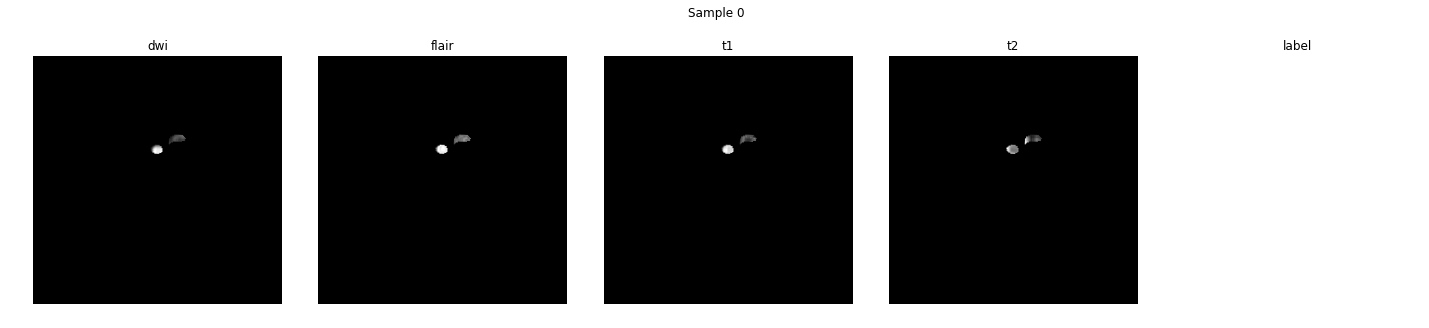

In [212]:
# Helper function to show a batch
def show_batch(sample_batched):
    """Show scans with labels for a batch of samples."""
    images_batch, labels_batch = \
            sample_batched['scan'], sample_batched['label']
    batch_size = len(images_batch)

    for i in range(batch_size):
        scan, label = torch.transpose(images_batch[i], 0, -1), \
                      torch.transpose(labels_batch[i], 0, -1)    
        
        stack = torch.cat([scan, label], -1)
        
        viz_sample(0, pass_sample=stack)
        
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['scan'].size(),
          sample_batched['label'].size())
    
    show_batch(sample_batched)
    break

Mask-RCNN Model Building

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [17]:
from vision.references.detection.engine import train_one_epoch, evaluate
import vision.references.detection.utils as utils

ModuleNotFoundError: No module named 'pycocotools'

In [ ]:


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFuda nDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=device)

    print("That's it!")